In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [104]:
# %%writefile ../src/color_composit.py

# %load ../src/numcolorpy.py
#                                                     REWRITE w proper PIL calls
# %load ../../FlyingMachineFractal/src/numcolorpy.py
"""
numcolorpy.py
Created Saturday April 22 2017

import numcolorpy as ncp
"""
import os
import time
from collections import OrderedDict

import numpy as np

import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# from colorspacious import cspace_converter
# from PIL import Image
from PIL import TiffImagePlugin as tip

from PIL import Image as IP

from PIL import ImageColor as IC
# import colorsys

"""                          Classes of Color Maps == Categories            """
cmaps = {}
cmaps['Perceptually_Uniform_Sequential'] = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

cmaps['Sequential'] = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                       'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                       'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

cmaps['Sequential (2)'] = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
                           'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
                           'hot', 'afmhot', 'gist_heat', 'copper']

cmaps['Diverging'] = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
                      'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']

cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

cmaps['Miscellaneous'] = ['flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
                          'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
                          'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']

cmap_list = []

for k, v in cmaps.items():
    for vv in v:
        cmap_list.append(vv)

cmap_list = sorted(list(set(cmap_list)))
print(len(cmap_list), 'color maps available')

def show_color_maps(n_cols=5):
    acum = []
    for m in sorted(cmap_list):
        #print(m)
        if len(acum) < n_cols:
            acum.append(m)
        else:
            s = ''
            for a in acum:
                s += '%18s'%(a)
            print(s)
            acum = []
    if len(acum) > 0:
        s = ''
        for a in acum:
            s += '%18s'%(a)
        print(s)


def range_norm(Z, lo=0.0, hi=1.0):
    """ normaize input matrix Z within a lo - hi range 
    """
    I = graphic_norm(Z)
    hi = max(min(hi, 1.0), 0.0)
    lo = min(max(lo, 0.0), 1.0)
    low_fence = min(hi, lo)
    hi_fence = max(hi, lo)

    if low_fence == hi_fence:
        return I
    
    v_span = hi_fence - low_fence
    I = I * v_span + low_fence
    
    return I

def raw_graphic_norm(Z0, Z, ET):
    """ Zd, Zr, ETn = raw_graphic_norm(Z0, Z, ET)
    noramize escape time algorithm output for color mapping input
    
    Args:
        Z0:     matrix of complex starting points
        Z:      matrix of final points (complex)
        ET:     Escape-Time -- number of iterations
        
    Returns:
        Zd:     normalized rotation distance (Z0, Z) matrix
        Zr:     normalized rotation difference (Z0, Z) matrix
        ETn:    normalized Escape Time matrix
    """
    ETn = graphic_norm(ET)
    Zv = Z - Z0
    Zd = graphic_norm(Zv)
    Zr = graphic_norm(np.arctan2(np.imag(Zv), np.real(Zv)))
    
    return Zd, Zr, ETn
    
def etg_norm(Z0, Z, ET):
    """ Zd, Zr, ETn = etg_norm(Z0, Z, ET); Graphically usable matrices from escape time algorithm result 
    Args:
        Z0:     matrix of complex starting points
        Z:      matrix of final points (complex)
        ET:     Escape-Time -- number of iterations
        
    Returns:
        Zd:     distance -- flattend norm (0.0, 1.0) absolute value of difference |Z - Z0|
        Zr:     flattend norm of rotation difference
        ETn:    flattend norm Escape Time matrix
    """
    ETn = mat2graphic(ET)
    Zv = Z - Z0
    Zd = mat2graphic(Zv)
    Zr = mat2graphic(np.arctan2(np.imag(Zv), np.real(Zv)))
    return Zd, Zr, ETn


def mat2graphic(Z):
    """ M, nClrs = mat2graphic(Z)
        Use all the transformation tricks to prepare input matrix Z
        for conversion to a viewable image.
        
    Args:
        Z:      real or complex (rows x xcols x 1) matrix
        
    Returns:
        M:      real (rows x xcols x 1) matrix (0 <= M <= 1)
    """
    M, nClrs = flat_index(np.abs(Z))
    return graphic_norm(M)


def graphic_norm(Z):
    """ rescale matrix z to distance (float) s.t.   
        0 <= z <= 1  (will include 0,1 if it has more than 1 value)
  
    Args:
        Z: is a real or complex two dimensional matrix
    
    Returns:
        Z: same size, real valued matrix with smallest member = 0, largest = 1
    """
    EPSILON = 1e-15
    I = np.abs(Z)
    I = I - I.min()
    
    return I / max(EPSILON, I.max())


def flat_index(float_mat):
    """ convert the input matrix to integers from 0 to number of unique values.
    
    Args:
        float_mat: two dimensional matrix.
        
    Return:
        float_mat: re-enumerated so that the matrix values are all sequential ints.
        n_colors:  number of unique values in the input / output matrix
    """
    rows = float_mat.shape[0]
    cols = float_mat.shape[1]

    float_mat = np.reshape(float_mat, (1, float_mat.size))
    ixA = np.argsort(float_mat)[0]
    
    current_value = float_mat[0, ixA[0]]
    enumeration_value = 0
    for ix in ixA:
        if float_mat[0,ix] != current_value:
            current_value = float_mat[0,ix]
            enumeration_value += 1
        float_mat[0,ix] = enumeration_value
    
    float_mat = np.array(np.reshape(float_mat, (rows, cols)))
    float_mat = np.int_(float_mat)
    n_colors = enumeration_value + 1
    
    return float_mat, n_colors

# def gray_mat(V):
# def rgb_2_hsv_mat(H, S, V):
# def mat_to_gray(V, max_v=255, min_v=0):
# def mat_to_red(V):
# def mat_to_green(V):
# def mat_to_blue(V):
# def mat_to_Shade(V, R_max, G_max, B_max, R_floor=0, G_floor=0, B_floor=0):
# def resize_color_map(mp0, n_colors):
# def normat_hsv_intrgb(H, S, V, H_max=1.0, H_min=0.0, S_max=1.0, S_min=0.0, V_max=1.0, V_min=0.0):
# def mat_to_mapped(A, mp):

def im_map(imfile_name, cmap_name='gist_gray', thumb_size=None):
    """ im = im_map(imfile_name, cmap_name='gist_gray', thumb_size=None)
    """
    if isinstance(cmap_name, LinearSegmentedColormap):
        cm_hot = cmap_name
    else:
        cm_hot = mpl.cm.get_cmap(cmap_name)
        
    img_src = Image.open(imfile_name).convert('L')
    
    if not thumb_size is None:
        img_src.thumbnail((thumb_size[0],thumb_size[1]))
        
    im = np.array(img_src)
    im = cm_hot(im)
    im = np.uint8(im * 255)
    im = Image.fromarray(im)
    
    return im


def get_grey_thumb(imfile_name):
    """ im = get_grey_thumb(imfile_name):
    """
    thumb_size = (512,512)
    c_map = mpl.cm.get_cmap('Greys')
    img_src = Image.open(imfile_name).convert('L')
    img_src.thumbnail(thumb_size)
    im = np.array(img_src)
    im = c_map(im)
    im = np.uint8(im * 255)
    im = Image.fromarray(im)
    
    return im

def get_etg_im(ET, Z, Z0):
    """ get a color image from  the products of the escape-time-algorithm Using HSV - RGB model:
    ETn         normalized escape time matrix           Hue
    Zr          normalized rotation of |Z - Z0|         Saturation
    Zd          normalized magnitude of |Z - Z0|        Value
    
    Args:
        ET:     (Integer) matrix of the Escape Times    
        Z:      (complex) matrix of the final vectors   
        Z0:     (complex) matrix of the starting plane
        
    Returns:
        I:      RGB PIL image

    """
    n_rows = Z0.shape[0]
    n_cols = Z0.shape[1]
    
    Zd, Zr, ETn = ncp.etg_norm(Z0, Z, ET)
    
    A = np.zeros((n_rows, n_cols,3))
    A[:,:,0] += ETn     # Hue
    A[:,:,1] += Zr      # Saturation
    A[:,:,2] += Zd      # Value
    
    I = PIL.Image.fromarray(np.uint8(A * 255), 'HSV').convert('RGB')
    
    return I

82 color maps available


In [16]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time

sys.path.insert(0, '../src/')
sys.path.insert(0, 'scalygraphic/src/')

# import zplain as zp
# import eq_iter
# import deg_0_ddeq
# import numcolorpy as ncp
from im_scale_products import *

In [17]:
run_parameters = get_default_run_parameters(results_dir=None)
for k, v in run_parameters.items():
    print('%40s: %s'%(k,v))
for eq_name, n in EQUS_DICT_NAMED_IDX.items():
    print(n, eq_name)

                            center_point: 0j
                                    zoom: 0.5
                                   theta: 0.0
                                  it_max: 64
                              scale_dist: 12
                                   max_d: 24.0
                                  n_rows: 256
                                  n_cols: 256
                                dir_path: /Users/mojo/git_clone/dlanier/scalygraphic/notebooksColorMapping/results
0 ElGato
1 IslaLace
2 ItchicuPpwrF
3 Nautuliz
4 RoyalZ
5 bugga_bear
6 de_Okeeffe
7 decPwrAFx
8 dreadSkull
9 nlC3
10 starfish_ish
11 starfish_ish_II
12 thunderHead


5.367133140563965 s


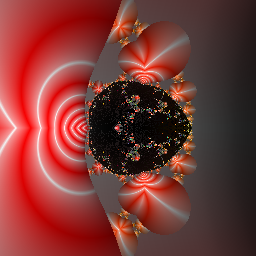

In [20]:
run_parameters = get_default_run_parameters(results_dir=None)
if os.path.isdir(run_parameters['dir_path']) == False:
    os.makedirs(run_parameters['dir_path'])
    
fcn_name = 'nlC3'
eq = EQUS_DICT[EQUS_DICT_NAMED_IDX[fcn_name]][1]
p = eq(1, None)

list_tuple = [(eq, (p))]

t0 = time.time()
ET, Z, Z0 = eq_iter.get_primitives(list_tuple, run_parameters)
tt = time.time() - t0
print(tt, 's')
im = get_etg_im(ET, Z, Z0)
display(im)

In [ ]:
#                          Rotate image:
run_parameters = get_default_run_parameters(results_dir=None)
run_parameters['theta'] = np.pi / 2
t0 = time.time()
ET, Z, Z0 = eq_iter.get_primitives(list_tuple, run_parameters)
tt = time.time() - t0

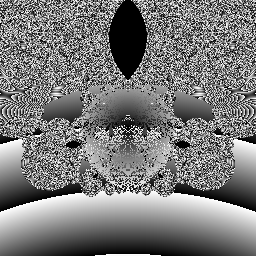

In [228]:
def primitive_2_gray(P):
    n_rows = P.shape[0]
    n_cols = P.shape[1]
    
    A = np.zeros((n_rows, n_cols,3))
    A[:,:,0] += P     # Hue
    A[:,:,1] += P      # Saturation
    A[:,:,2] += P      # Value
    
    I = tip.Image.fromarray(np.uint8(A * 255), 'RGB').convert('L')
    
    return I

def map_raw_etg(Z0, Z, ET, c_map_name='afmhot'):
    
    n_rows = ET.shape[0]
    n_cols = ET.shape[1]

    Zd, Zr, ETn = etg_norm(Z0, Z, ET)
    
    c_map = mpl.cm.get_cmap(c_map_name)
    im = c_map(Zd)
    im = np.uint8(im * 255)
    im = tip.Image.fromarray(im)
    
    return im

def map_etg_composite(Z0, Z, ET, c_map_name='afmhot'):
    im = np.array(get_etg_im(ET, Z, Z0).convert('L'))

    c_map = mpl.cm.get_cmap(c_map_name)
    im = c_map(im)
    
    im = np.uint8(im * 255)
    im = tip.Image.fromarray(im)
    
    return im

    
g_im = primitive_2_gray(np.abs(Z - Z0))
display(g_im)

(256, 256)


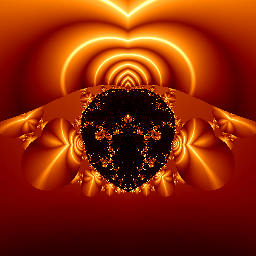

In [227]:
do_im = map_etg_composite(Z0, Z, ET, c_map_name='afmhot')
display(do_im)

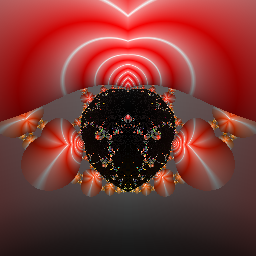

In [153]:
im = get_etg_im(ET, Z, Z0)
display(im)

In [213]:
color_number = 80

[0.161145800333, 0.370248409961, 0.119609846764]
winter 81 of 82


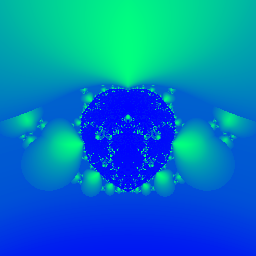

In [219]:
print(p)
# Zd, Zr, ETn = raw_graphic_norm(Z0, Z, ET)
# im_g = primitive_2_gray(Zd)
grey_list = ['binary', 'gist_gray', 'gist_yarg', 'Greys', 'gray']
good_list = ['afmhot', 'bone', 'copper', 'flag', 'gist_earth', 
             'gist_heat', 'gist_ncar', 'gist_stern', 'gnuplot2', 
             'hot', 'inferno', 'jet', 'nipy_spectral', 'prism', 
             'rainbow', 'seismic', 'tab20b', 'tab20c', 'terrain']
c_map_name = cmap_list[color_number]
im = map_raw_etg(Z0, Z, ET, c_map_name)
print(c_map_name, color_number, 'of', len(cmap_list))
if color_number + 1 < len(cmap_list):
    color_number += 1
display(im)

In [215]:
show_color_maps(6)

            Accent             Blues              BrBG              BuGn              BuPu            CMRmap
              GnBu            Greens             Greys              OrRd           Oranges              PRGn
           Pastel1           Pastel2              PiYG              PuBu            PuBuGn              PuOr
           Purples              RdBu              RdGy              RdPu            RdYlBu            RdYlGn
              Set1              Set2              Set3          Spectral            Wistia              YlGn
            YlOrBr            YlOrRd            afmhot            autumn            binary              bone
               bwr           cividis              cool          coolwarm            copper         cubehelix
        gist_earth         gist_gray         gist_heat         gist_ncar      gist_rainbow        gist_stern
           gnuplot          gnuplot2              gray               hot               hsv           inferno
             magma 

In [252]:
good_list = ['afmhot', 'bone', 'copper', 'flag', 'gist_earth', 
             'gist_heat', 'gist_ncar', 'gist_stern', 'gnuplot2', 
             'hot', 'inferno', 'jet', 'nipy_spectral', 'prism', 
             'rainbow', 'seismic', 'tab20b', 'tab20c', 'terrain']
grey_list = ['binary', 'gist_gray', 'gist_yarg', 'Greys', 'gray']
good_list_number = 0

gray


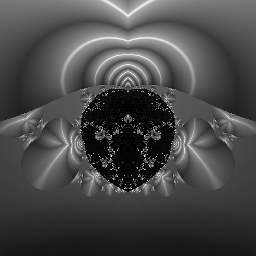

In [258]:
c_map_name = grey_list[good_list_number]
do_im = map_etg_composite(Z0, Z, ET, c_map_name)
print(c_map_name)
if good_list_number + 1 < len(good_list):
    good_list_number += 1
display(do_im)

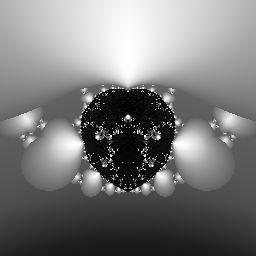

In [254]:
# etg_norm
Zd, Zr, ETn = etg_norm(Z0, Z, ET)
im_g = primitive_2_gray(Zd)
display(im_g)